<a href="https://colab.research.google.com/github/clementine-lev/MLproject/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Business Problem
The objective of this project is to predict bicycle traffic in the Lyon metropolitan area using machine learning models.

Initially, weather data was considered, but it could not be reliably merged with the bicycle traffic dataset because weather observations were available at a daily level, while bicycle counts were aggregated annually. As a result, the final prediction relies exclusively on infrastructure, spatial, and contextual features, including:

- number of lanes,

- sensor type and measurement post type,

- peak flow hour,

- reference year,

- geographic location (longitude and latitude),

- commune where the sensor is located,

- population of the commune (population_2022).

These variables describe the physical capacity of the infrastructure, sensor characteristics, and local demographic context, all of which are expected to influence cycling activity.

This model can support several real-world applications:

- urban planning, by identifying areas where cycling demand is high or underestimated,

- infrastructure investment decisions, such as prioritizing new bike lanes,

- analysis of spatial patterns in cycling behavior across communes,

- prediction of baseline cycling flows in locations without permanent sensors.

The target variable is the average weekday bicycle count, which represents typical cycling activity on working days and provides a stable indicator of everyday mobility patterns.

In [15]:
# 0) Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# only for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.max_columns", 200)

In [16]:



# 1) settings

INFRA_FILE = "comptage.csv"
COMMUNES_GEOJSON = "metropole-de-lyon_ter_territoire.population_communale.json"
REMOVE_LEAK_FEATURE = True  # True = remove max_hourly_flow from features
RANDOM_STATE = 42


# 2) Loading infrastructure dataset
infra = pd.read_csv(INFRA_FILE, sep=";")
infra = infra[infra["typepostemesure"] == "Comptage vélo"].copy()

print("\nINFRA PREVIEW")
print(infra.head())
print("\nINFRA SHAPE:", infra.shape)

# 3) Construction of df_infra and sanitize coordinates

df_infra = infra.copy()

# Sanitizing lon/lat
for col in ["lon", "lat"]:
    df_infra[col] = df_infra[col].astype(str).str.replace(",", ".", regex=False)
    df_infra[col] = pd.to_numeric(df_infra[col], errors="coerce")

# Dropping rows without coordinates
df_infra = df_infra.dropna(subset=["lon", "lat"]).copy()

# 4) Create GeoDataFrame for sensors
gdf_sensors = gpd.GeoDataFrame(
    df_infra,
    geometry=gpd.points_from_xy(df_infra["lon"], df_infra["lat"]),
    crs="EPSG:4326"
)

# 5) Loading communes polygons + population and spatial join

gdf_communes = gpd.read_file(COMMUNES_GEOJSON).to_crs("EPSG:4326")

# Keeping only useful columns
commune_name_col = "nom"
population_col = "pop2022"

gdf_communes_clean = gdf_communes[[commune_name_col, population_col, "geometry"]].copy()
gdf_communes_clean = gdf_communes_clean.rename(columns={commune_name_col: "commune"})

joined = gpd.sjoin(
    gdf_sensors,
    gdf_communes_clean,
    how="left",
    predicate="within"
)

# Fallbacks
joined["commune"] = joined["commune"].fillna("Outside Lyon Metropolis")

if population_col not in joined.columns:
    joined[population_col] = np.nan

joined[population_col] = pd.to_numeric(joined[population_col], errors="coerce")
joined[population_col] = joined[population_col].fillna(joined[population_col].median())

# 6) Construction of df_final with English column names
required_cols = [
    "moyennejoursouvrable",
    "distancelignearret",
    "nbvoies",
    "horairedebitmax",
    "debithorairemax",
    "typecapteur",
    "typepostemesure",
    "anneereference",
    "lon",
    "lat",
    "commune",
    population_col,
]

missing_required = [c for c in required_cols if c not in joined.columns]
if missing_required:
    raise ValueError(f"Missing required columns in joined data: {missing_required}")

df_final = joined[required_cols].copy()

# Renaming columns (English)
df_final = df_final.rename(columns={
    "moyennejoursouvrable": "average_week_day_bike_count",
    "distancelignearret": "distance_to_stop_line",
    "nbvoies": "number_of_lanes",
    "horairedebitmax": "peak_flow_hour",
    "debithorairemax": "max_hourly_flow",
    "typecapteur": "sensor_type",
    "typepostemesure": "measurement_post_type",
    "anneereference": "reference_year",
    "lon": "longitude",
    "lat": "latitude",
    population_col: "population_2022"
})

# Cleaning target and year
df_final["reference_year"] = pd.to_numeric(df_final["reference_year"], errors="coerce")
df_final = df_final.dropna(subset=["average_week_day_bike_count"]).copy()

print("\nDF_FINAL READY")
print(df_final.head())
print(df_final.info())


# 7) Removing max_hourly_flow everywhere

if REMOVE_LEAK_FEATURE:
    df_final = df_final.drop(columns=["max_hourly_flow"], errors="ignore")
    print("\nmax_hourly_flow removed from df_final (not used in EDA or ML).")


# 8) Target + feature lists
TARGET = "average_week_day_bike_count"

# Defining initial features for VIF check
numeric_features_vif = [
    "distance_to_stop_line",
    "number_of_lanes",
    "reference_year",
    "longitude",
    "latitude",
    "population_2022"
]


# 9) VIF (Variance Inflation Factor)
X_num = df_final[numeric_features_vif].copy()
X_num_tmp = X_num.fillna(X_num.median(numeric_only=True))

vif_data = pd.DataFrame({
    "feature": X_num_tmp.columns,
    "VIF": [variance_inflation_factor(X_num_tmp.values, i) for i in range(X_num_tmp.shape[1])]
})

print("\nVIF (numeric features)")
print(vif_data)


# 10) Preprocessing & Final Feature Selection
cols_to_drop = [
    'positionnement',
    'nom',
    'identifiantptm',
    'identifiantcontroleur',
    'peak_flow_hour',
    'gid'
]

# Drop unwanted columns if they exist
X = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns], errors='ignore')
X = X.drop(columns=[TARGET], errors='ignore')
y = df_final[TARGET]

# Dynamically select numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("\nFINAL FEATURES USED:")
print("Numerical:", numerical_features)
print("Categorical:", categorical_features)

# Define Pipelines
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

# 11) Train/test split & Evaluation Function

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

def evaluate_model(name, model, X_test, y_test):
    """
    Evaluates a model and prints metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name}")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

    return mae, rmse, r2, y_pred

results = []



INFRA PREVIEW
   positionnement  distancelignearret                           nom  \
0         1789_VL                   0        1789_Velo_Delandine_SN   
6          652_CS                   0     652_Velo_La_Feuillee_O/ E   
26       1599_SN1                   0     1599_Velo_Joliot_Curie_SN   
56         644_CS                   0            644_Velo_Bertin_OE   
79       1604_VN1                   0  1604_Velo_Genas_Lacouture_EO   

                typecapteur typepostemesure  nbvoies  moyennejoursouvrable  \
0   Capteur inductif Criter   Comptage vélo        1                 563.0   
6   Capteur inductif Criter   Comptage vélo        1                1555.0   
26  Capteur inductif Criter   Comptage vélo        1                 370.0   
56  Capteur inductif Criter   Comptage vélo        1                1155.0   
79  Capteur inductif Criter   Comptage vélo        1                 307.0   

    debithorairemax horairedebitmax  identifiantptm  identifiantcontroleur  \
0          

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


# Modelisation and comparaison


Linear Regression
MAE: 590.12 | RMSE: 701.91 | R²: 0.234

Lasso Regression
MAE: 590.10 | RMSE: 701.90 | R²: 0.234


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e+07, tolerance: 2.466e+04
  model = cd_fast.enet_coordinate_descent(



Decision Tree
MAE: 86.63 | RMSE: 223.05 | R²: 0.923

Random Forest
MAE: 138.90 | RMSE: 194.18 | R²: 0.941

Tuned Random Forest — Best Params:
{'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__n_estimators': 100}

Random Forest (Tuned)
MAE: 190.77 | RMSE: 239.29 | R²: 0.911

Gradient Boosting Regressor
MAE: 181.51 | RMSE: 237.76 | R²: 0.912


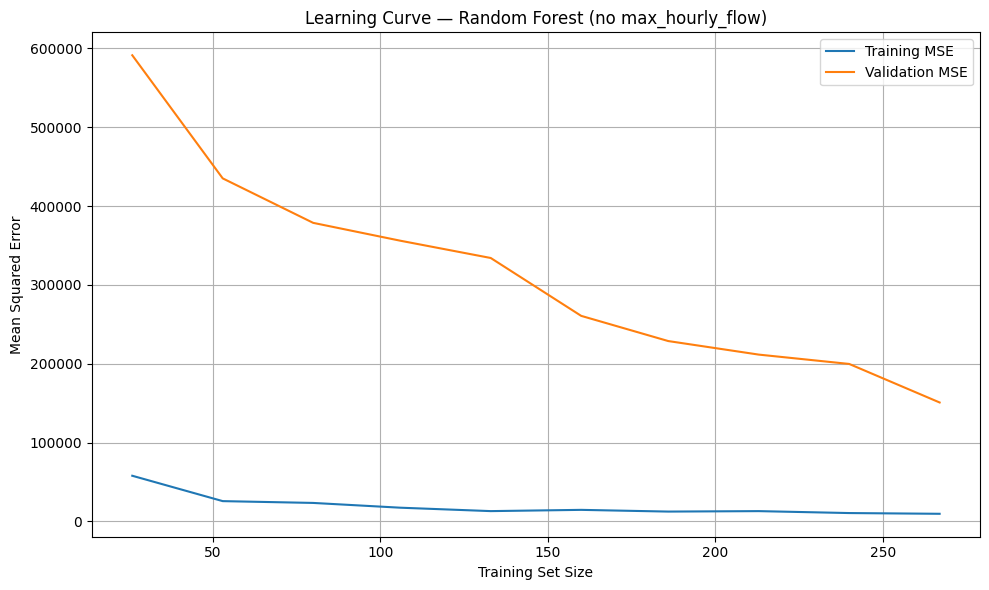


SUMMARY OF MODEL PERFORMANCE
| Model                       |    R2 |   RMSE |    MAE |
|:----------------------------|------:|-------:|-------:|
| Linear Regression           | 0.234 | 701.91 | 590.12 |
| Lasso Regression            | 0.234 | 701.9  | 590.1  |
| Decision Tree               | 0.923 | 223.05 |  86.63 |
| Random Forest               | 0.941 | 194.18 | 138.9  |
| Random Forest (Tuned)       | 0.911 | 239.29 | 190.77 |
| Gradient Boosting Regressor | 0.912 | 237.76 | 181.51 |


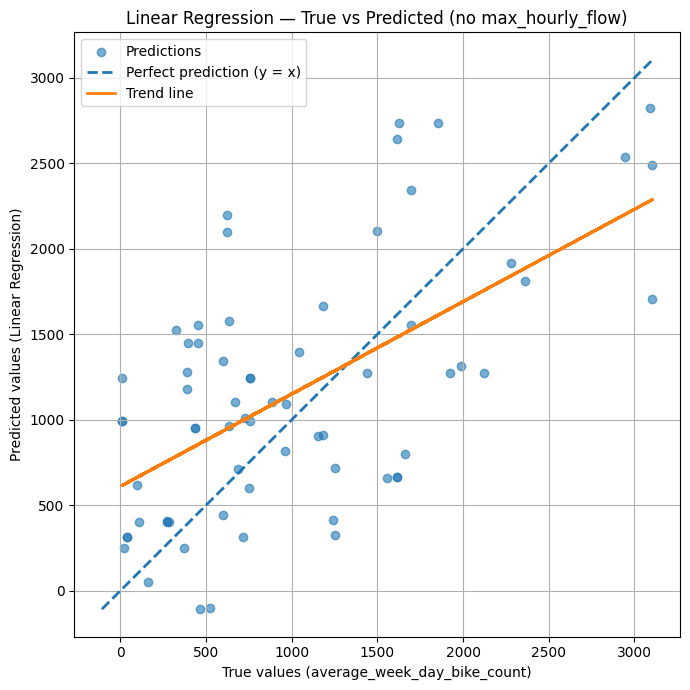

In [17]:
# Model 1 — Linear Regression
linreg = Pipeline(steps=[
("preprocessor", preprocessor),
("model", LinearRegression())
])
linreg.fit(X_train, y_train)
mae_lin, rmse_lin, r2_lin, y_pred_lin = evaluate_model("Linear Regression", linreg, X_test, y_test)
results.append(("Linear Regression", r2_lin, rmse_lin, mae_lin))
# Model 2 — Lasso Regression
lasso = Pipeline(steps=[
("preprocessor", preprocessor),
("model", Lasso(alpha=0.001, max_iter=20000))
])
lasso.fit(X_train, y_train)
mae_lasso, rmse_lasso, r2_lasso, y_pred_lasso = evaluate_model("Lasso Regression", lasso, X_test, y_test)
results.append(("Lasso Regression", r2_lasso, rmse_lasso, mae_lasso))
# Model 3 — Decision Tree
dt_model = Pipeline(steps=[
("preprocessor", preprocessor),
("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
])
dt_model.fit(X_train, y_train)
mae_dt, rmse_dt, r2_dt, y_pred_dt = evaluate_model("Decision Tree",
dt_model, X_test, y_test)
results.append(("Decision Tree", r2_dt, rmse_dt, mae_dt))
# Model 4 — Random Forest
rf_model = Pipeline(steps=[
("preprocessor", preprocessor),
("model", RandomForestRegressor(
n_estimators=200,
random_state=RANDOM_STATE,
n_jobs=-1
))
])
rf_model.fit(X_train, y_train)
mae_rf, rmse_rf, r2_rf, y_pred_rf = evaluate_model("Random Forest",
rf_model, X_test, y_test)
results.append(("Random Forest", r2_rf, rmse_rf, mae_rf))
# Model 5 — Tuned Random Forest (GridSearchCV)
param_grid = {
"model__n_estimators": [100, 200],
"model__max_depth": [10, 20],
"model__min_samples_leaf": [2, 4],
}
rf_cv = Pipeline(steps=[
("preprocessor", preprocessor),
("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-
1))
])
grid_search = GridSearchCV(
estimator=rf_cv,
param_grid=param_grid,
scoring="neg_mean_absolute_error",
cv=3,
n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\nTuned Random Forest — Best Params:")
print(grid_search.best_params_)
mae_best, rmse_best, r2_best, y_pred_best = evaluate_model("Random Forest (Tuned)", best_rf, X_test, y_test)
results.append(("Random Forest (Tuned)", r2_best, rmse_best, mae_best))
# Extra model — Gradient Boosting
gbr_model = Pipeline(steps=[
("preprocessor", preprocessor),
("model", GradientBoostingRegressor(random_state=RANDOM_STATE))
])
gbr_model.fit(X_train, y_train)
mae_gbr, rmse_gbr, r2_gbr, y_pred_gbr = evaluate_model("Gradient Boosting Regressor", gbr_model, X_test, y_test)
results.append(("Gradient Boosting Regressor", r2_gbr, rmse_gbr,
mae_gbr))
# 18) Learning curve (Random Forest)
train_sizes, train_scores, test_scores = learning_curve(
rf_model,
X, y,
cv=5,
scoring="neg_mean_squared_error",
train_sizes=np.linspace(0.1, 1.0, 10),
n_jobs=-1
)
train_mse = -train_scores.mean(axis=1)
test_mse = -test_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mse, label="Training MSE")
plt.plot(train_sizes, test_mse, label="Validation MSE")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve — Random Forest (no max_hourly_flow)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Summary table
summary = pd.DataFrame(results, columns=["Model", "R2", "RMSE", "MAE"])
summary["R2"] = summary["R2"].map(lambda x: f"{x:.3f}")
summary["RMSE"] = summary["RMSE"].map(lambda x: f"{x:.2f}")
summary["MAE"] = summary["MAE"].map(lambda x: f"{x:.2f}")
print("\nSUMMARY OF MODEL PERFORMANCE")
print(summary.to_markdown(index=False))
# Clean diagnostic plot: Linear Regression (True vs Predicted)
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_lin, alpha=0.6, label="Predictions")
min_val = min(y_test.min(), y_pred_lin.min())
max_val = max(y_test.max(), y_pred_lin.max())
plt.plot([min_val, max_val], [min_val, max_val],
linestyle="--", linewidth=2, label="Perfect prediction (y = x)")
m, b = np.polyfit(np.array(y_test), np.array(y_pred_lin), 1)
plt.plot(np.array(y_test), m*np.array(y_test) + b, linewidth=2,
label="Trend line")
plt.xlabel("True values (average_week_day_bike_count)")
plt.ylabel("Predicted values (Linear Regression)")
plt.title("Linear Regression — True vs Predicted (no max_hourly_flow)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 7) Graphics:

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


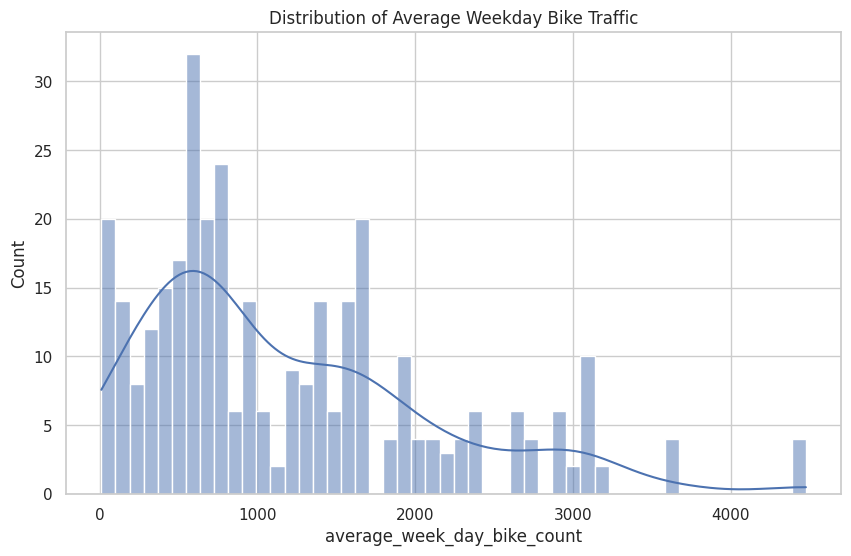

/tmp/ipython-input-1227593977.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_commune_avg,


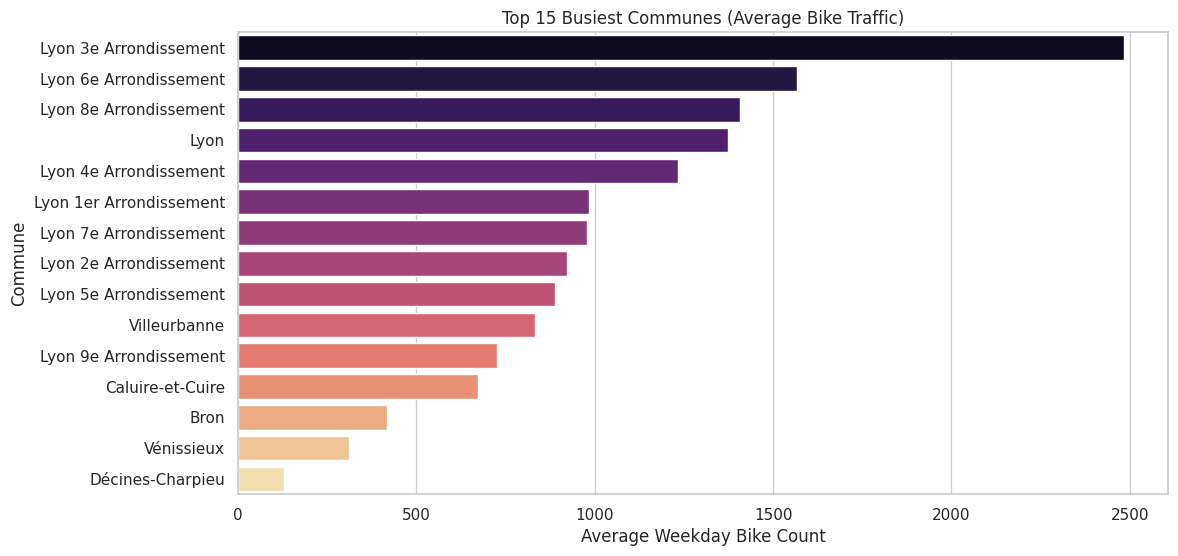

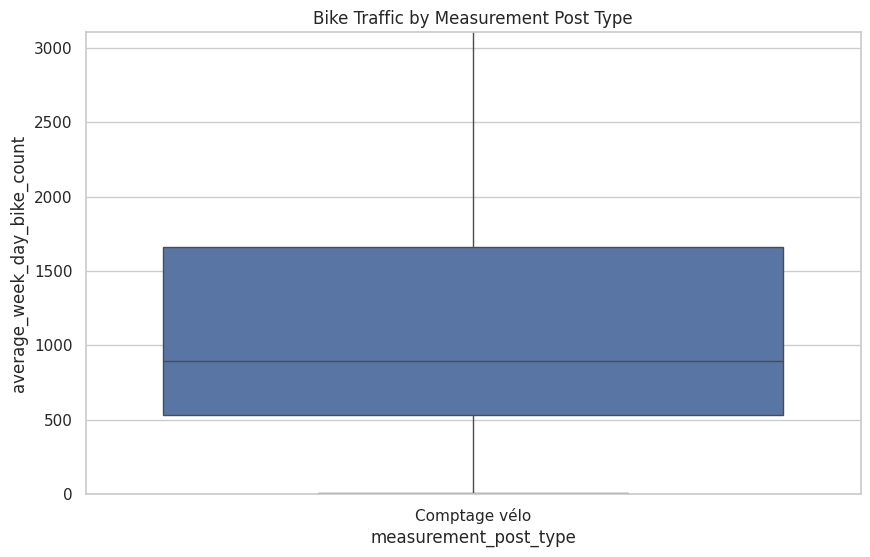

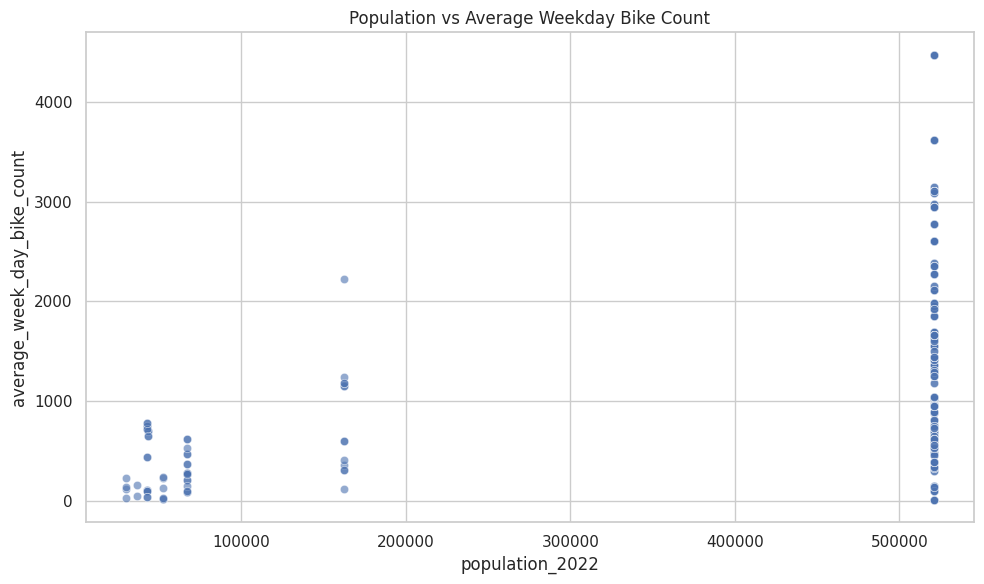

In [19]:


sns.set_theme(style="whitegrid")


# 1. GRAPHICS (EDA)


# 1.1 Distribution of traffic
plt.figure(figsize=(10,6))
sns.histplot(df_final["average_week_day_bike_count"], bins=50, kde=True)
plt.title("Distribution of Average Weekday Bike Traffic")
plt.show()

df_commune_avg = (
    df_final.groupby("commune")["average_week_day_bike_count"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)
#2 Top 15 Busiest Communes
plt.figure(figsize=(12,6))
sns.barplot(data=df_commune_avg,
            x="average_week_day_bike_count",
            y="commune",
            palette="magma")
plt.title("Top 15 Busiest Communes (Average Bike Traffic)")
plt.xlabel("Average Weekday Bike Count")
plt.ylabel("Commune")
plt.show()

# 1.3 Boxplot per measurement post type
plt.figure(figsize=(10,6))
sns.boxplot(data=df_final, x="measurement_post_type", y="average_week_day_bike_count")
plt.title("Bike Traffic by Measurement Post Type")
plt.ylim(0, df_final["average_week_day_bike_count"].quantile(0.95))
plt.show()
# 1.4 Scatter population_2022 vs target
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_final, x="population_2022", y="average_week_day_bike_count", alpha=0.6)
plt.title("Population vs Average Weekday Bike Count")
plt.tight_layout()
plt.show()








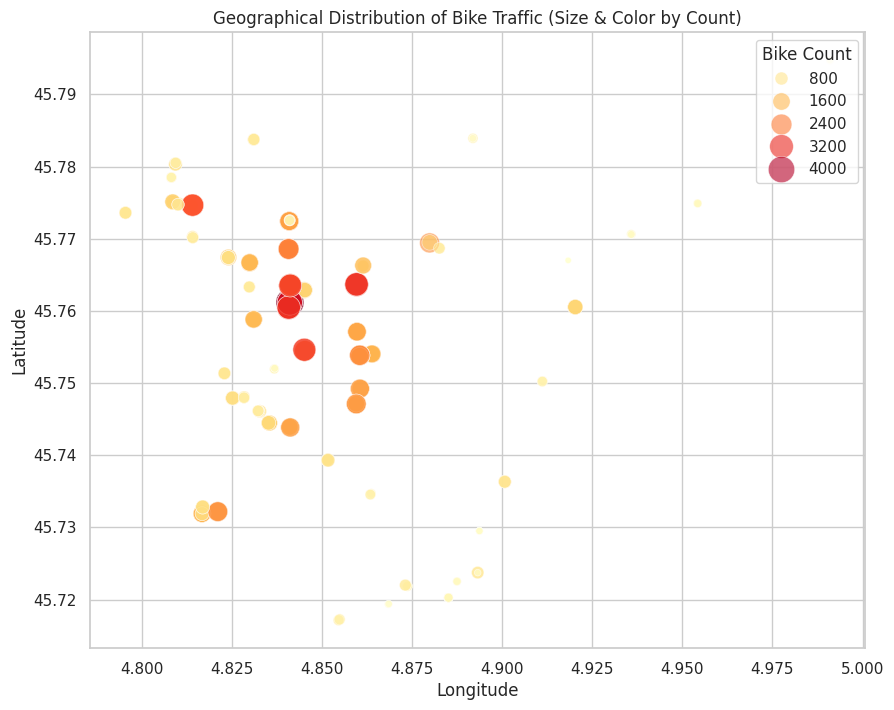

In [20]:
# Scatter Map of Traffic
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='average_week_day_bike_count',
                size='average_week_day_bike_count', data=df_final,
                palette='YlOrRd', sizes=(20, 400), alpha=0.6)
plt.title('Geographical Distribution of Bike Traffic (Size & Color by Count)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Bike Count', loc='upper right')
plt.show()

# *Interpretation:* We observe clear clusters of high bike traffic (large, dark circles) concentrated in specific geographical areas, likely city centers or critical transit points, demonstrating the importance of location.

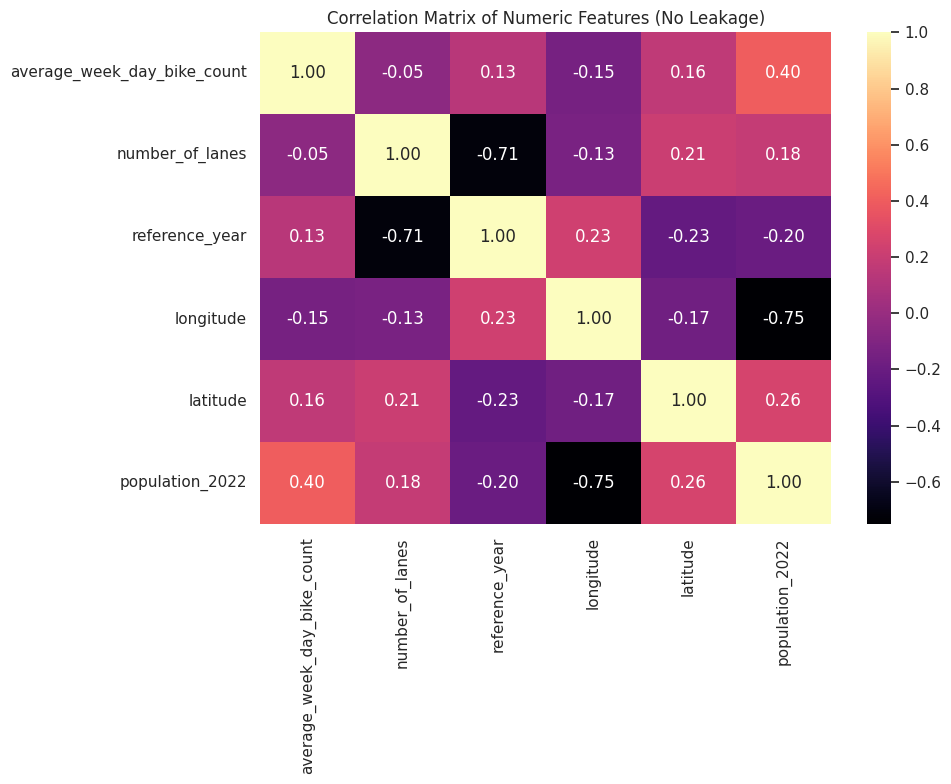

In [21]:
# Heat map
corr_cols = [
    'average_week_day_bike_count',
    'number_of_lanes',
    'reference_year',
    'longitude',
    'latitude',
    'population_2022'
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_final[corr_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="magma"
)
plt.title("Correlation Matrix of Numeric Features (No Leakage)")
plt.tight_layout()
plt.show()


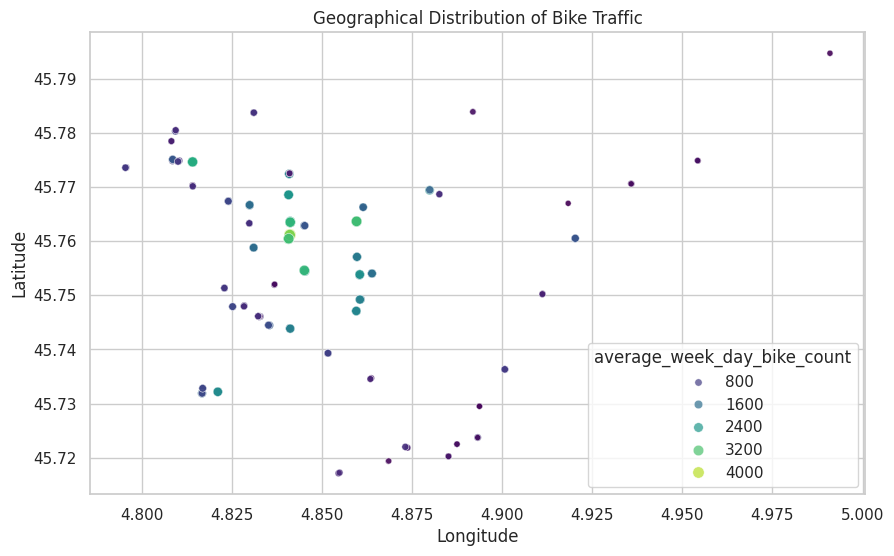

In [22]:
# Geographical Distribution of Bike Traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', size='average_week_day_bike_count',
                hue='average_week_day_bike_count', data=df_final, alpha=0.7, palette='viridis')
plt.title('Geographical Distribution of Bike Traffic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


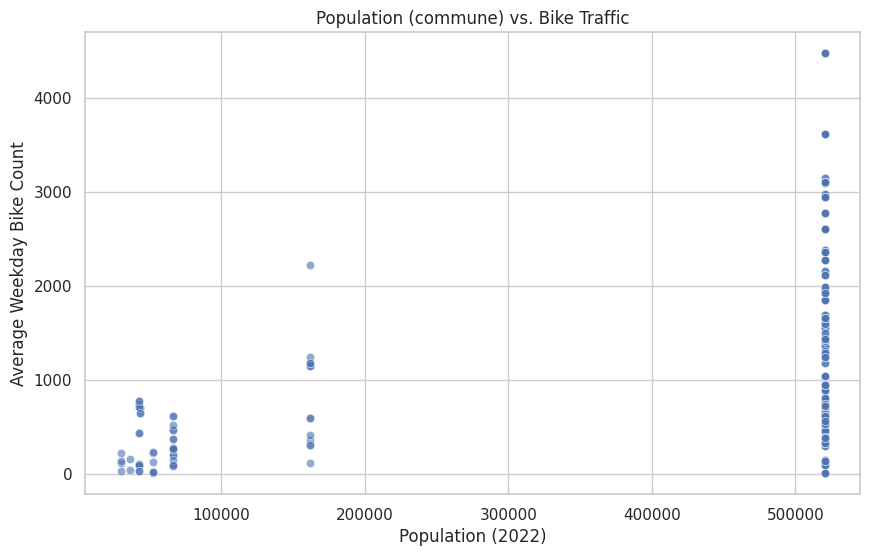

In [23]:
# Population (commune) vs. Bike Traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='population_2022',
    y='average_week_day_bike_count',
    data=df_final,
    alpha=0.6
)


plt.title('Population (commune) vs. Bike Traffic')
plt.xlabel('Population (2022)')
plt.ylabel('Average Weekday Bike Count')
plt.show()


In [24]:


#  Define Features and Target
target = 'average_week_day_bike_count'


cols_to_drop = [
    'positionnement',
    'nom',
    'identifiantptm',
    'identifiantcontroleur',
    'peak_flow_hour',
    'gid'
]

X = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns], errors='ignore')
X = X.drop(columns=[target], errors='ignore')

y = df_final[target]

#  Identifying numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

#  Preprocessing Pipelines
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)


Numerical Features: ['distance_to_stop_line', 'number_of_lanes', 'reference_year', 'longitude', 'latitude', 'population_2022']
Categorical Features: ['sensor_type', 'measurement_post_type', 'commune']


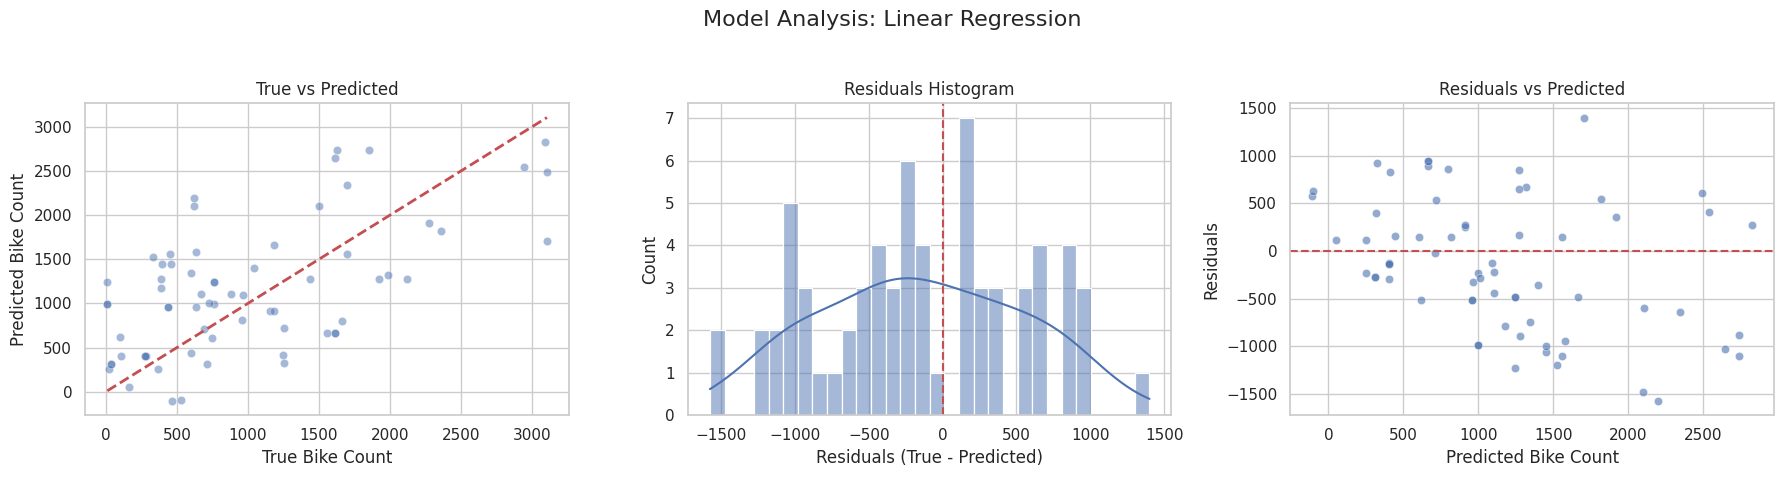


 Interpretation: Linear Regression 
• Strong heteroscedasticity detected: residual variance increases with predicted value.
 Linear model --> slight underfitting expected because relationships are highly nonlinear.
 Residuals patterns likely curved, confirming model bias.




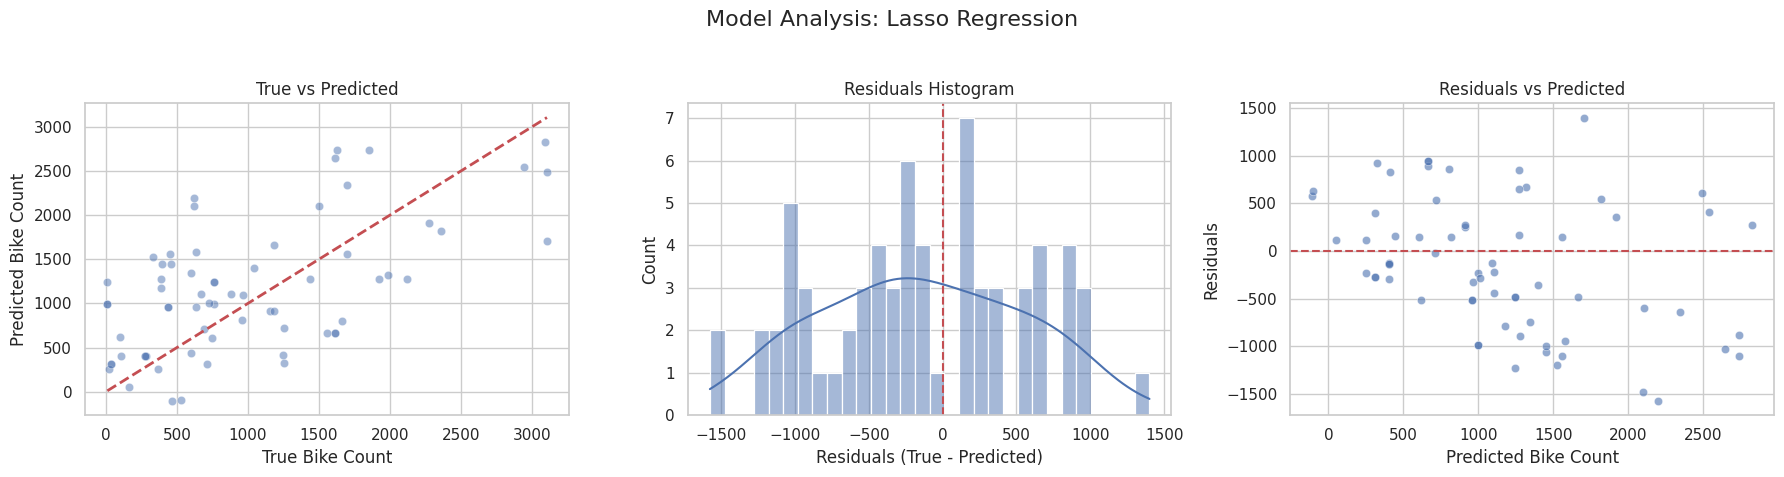


 Interpretation: Lasso Regression 
• Strong heteroscedasticity detected: residual variance increases with predicted value.
 Linear model --> slight underfitting expected because relationships are highly nonlinear.
 Residuals patterns likely curved, confirming model bias.




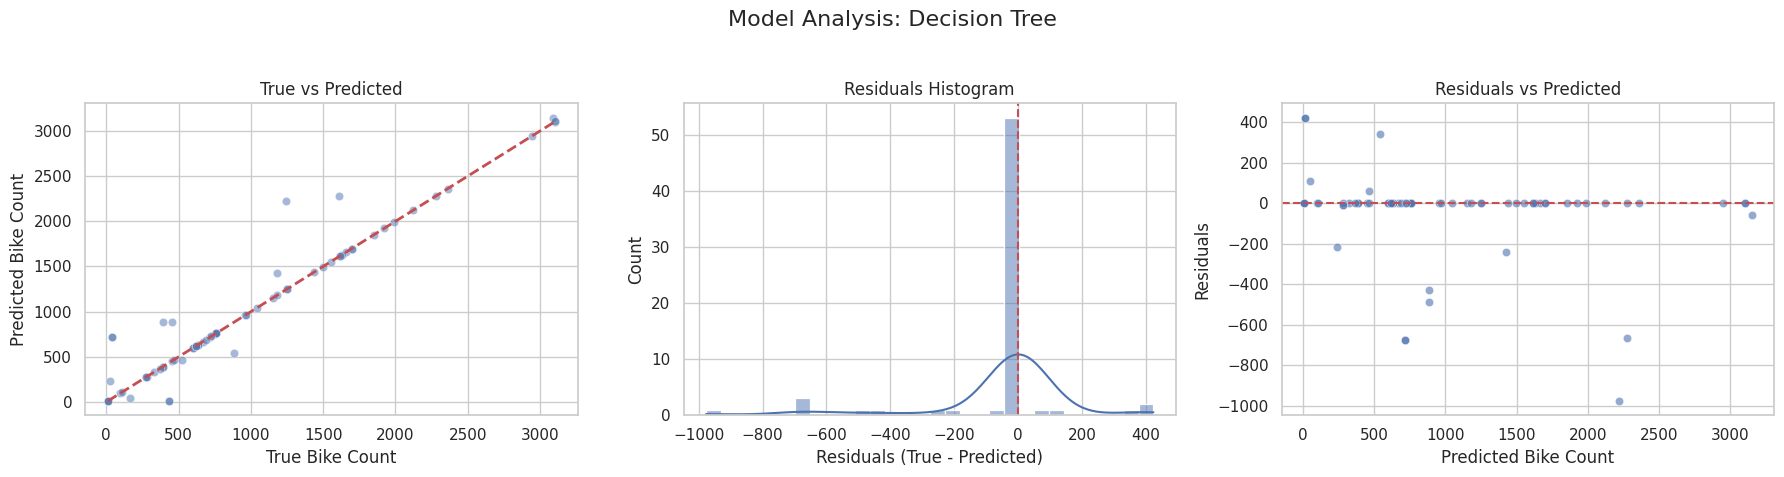


 Interpretation: Decision Tree 
• Residuals show limited heteroscedasticity.
 Tree-based models --> low bias, residuals centered around 0.
 Outliers may still appear due to extremely busy stations.




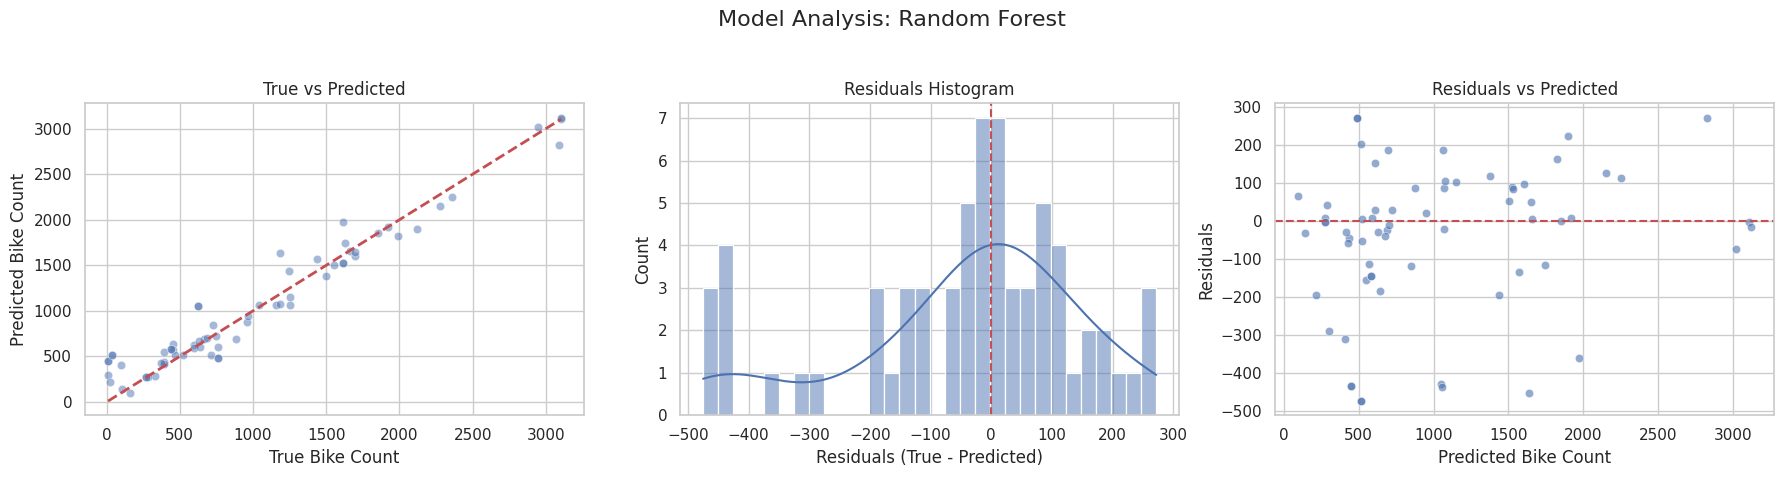


 Interpretation: Random Forest 
• Residuals show limited heteroscedasticity.
 Tree-based models --> low bias, residuals centered around 0.
 Outliers may still appear due to extremely busy stations.




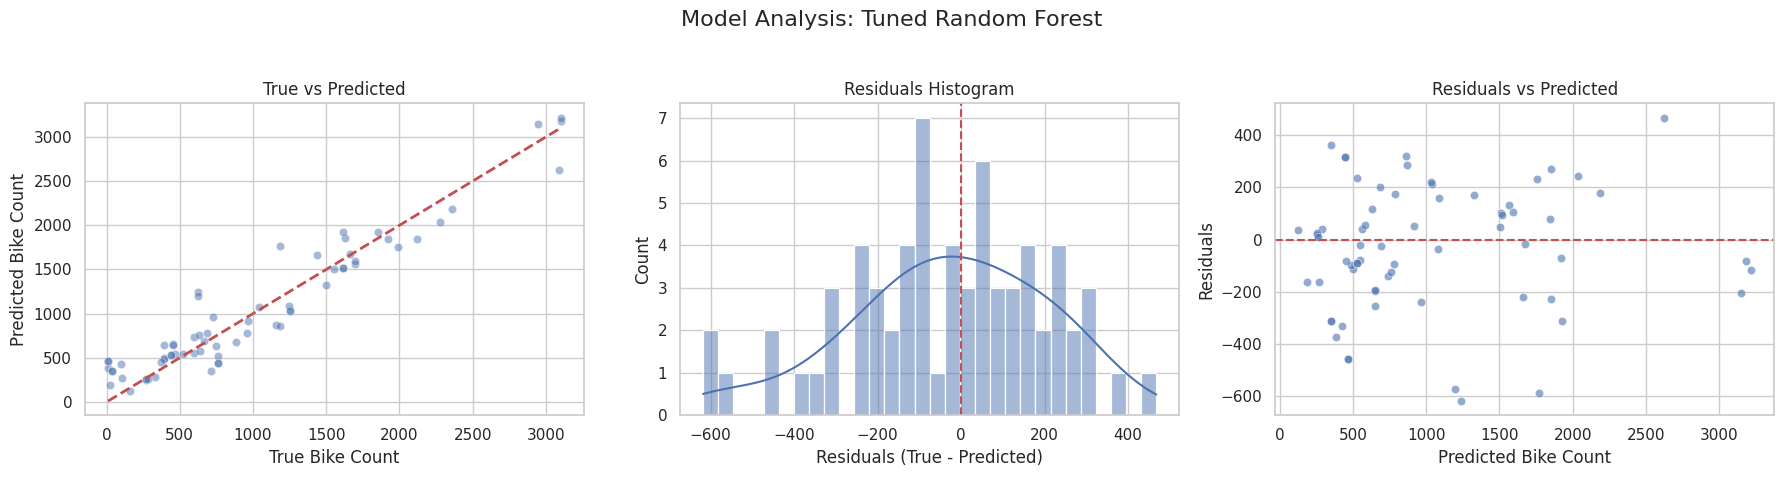


 Interpretation: Tuned Random Forest 
• Residuals show limited heteroscedasticity.
 Tree-based models --> low bias, residuals centered around 0.
 Outliers may still appear due to extremely busy stations.




In [25]:



# 1. Correct predictions dictionary

predictions_dict = {
    'Linear Regression': y_pred_lin,
    'Lasso Regression': y_pred_lasso,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Tuned Random Forest': y_pred_best
}


# 2. Function for full model diagnostic plots

def plot_model_analysis(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Model Analysis: {model_name}', fontsize=16)


    # 1. True vs Predicted

    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0], alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()],
                 'r--', lw=2)
    axes[0].set_title('True vs Predicted')
    axes[0].set_xlabel('True Bike Count')
    axes[0].set_ylabel('Predicted Bike Count')


    # 2. Residuals Histogram

    sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_title('Residuals Histogram')
    axes[1].set_xlabel('Residuals (True - Predicted)')


    # 3. Residuals vs Predicted

    sns.scatterplot(x=y_pred, y=residuals, ax=axes[2], alpha=0.6)
    axes[2].axhline(0, color='r', linestyle='--')
    axes[2].set_title('Residuals vs Predicted')
    axes[2].set_xlabel('Predicted Bike Count')
    axes[2].set_ylabel('Residuals')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # Interpretation

    spread_ratio = np.std(residuals) / np.mean(y_true)

    print(f"\n Interpretation: {model_name} ")

    if spread_ratio > 0.5:
        print("• Strong heteroscedasticity detected: residual variance increases with predicted value.")
    else:
        print("• Residuals show limited heteroscedasticity.")

    if model_name in ['Linear Regression', 'Lasso Regression']:
        print(" Linear model --> slight underfitting expected because relationships are highly nonlinear.")
        print(" Residuals patterns likely curved, confirming model bias.")
    else:
        print(" Tree-based models --> low bias, residuals centered around 0.")
        print(" Outliers may still appear due to extremely busy stations.")

    print("\n")


# 3. Generate plots for all models

for model_name, y_pred in predictions_dict.items():
    plot_model_analysis(y_test, y_pred, model_name)


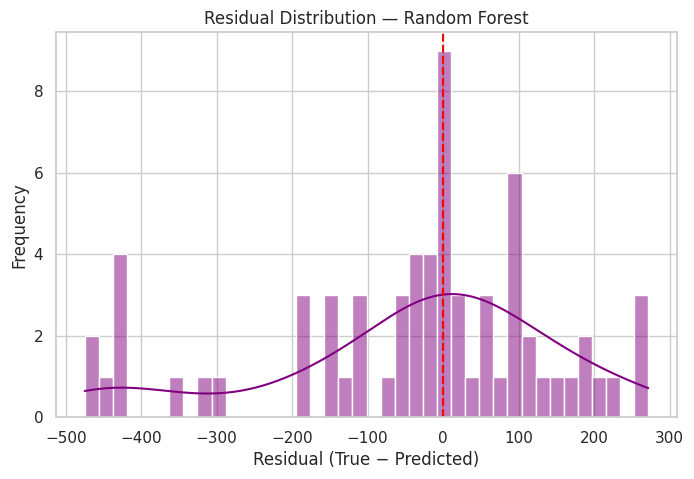

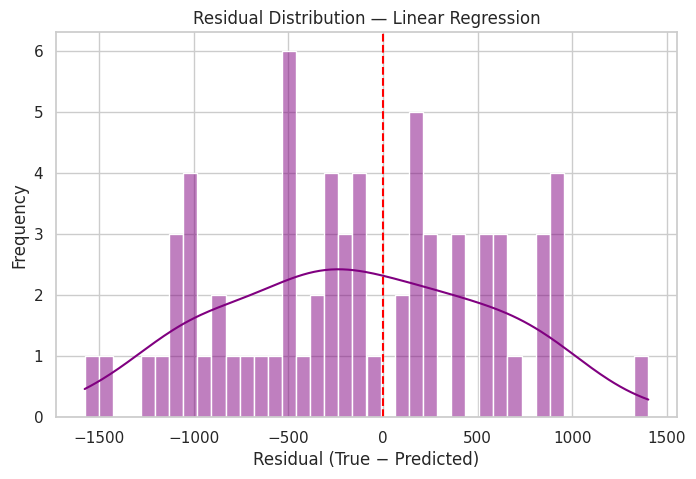

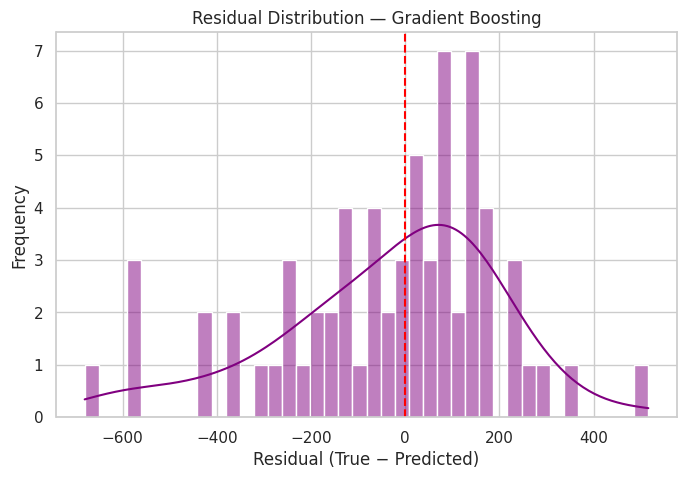

In [26]:
# Residual distribution
def plot_residual_distribution(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, color="purple", bins=40)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Residual Distribution — {model_name}")
    plt.xlabel("Residual (True − Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
plot_residual_distribution(y_test, y_pred_rf, "Random Forest")
plot_residual_distribution(y_test, y_pred_lin, "Linear Regression")
plot_residual_distribution(y_test, y_pred_gbr, "Gradient Boosting")



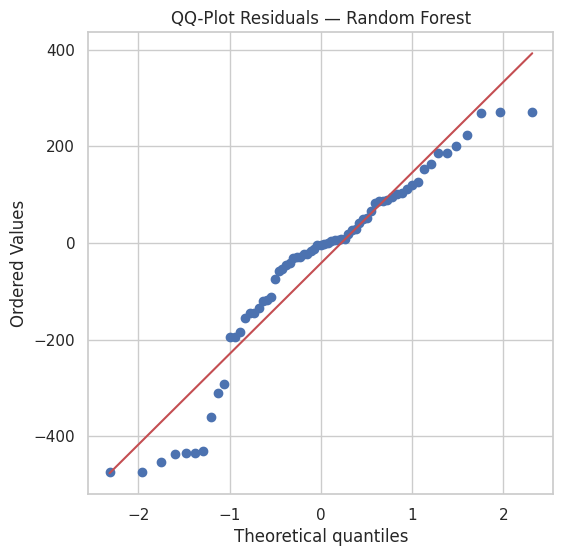

In [27]:


def plot_qq(residuals, model_name):
    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"QQ-Plot Residuals — {model_name}")
    plt.show()

plot_qq(y_test - y_pred_rf, "Random Forest")


In [28]:
def residual_vs_feature(feature_name, model, model_name):
    # 1. Predicting using full X_test
    pred = model.predict(X_test)

    # 2. Computing residuals
    residuals = y_test - pred

    # 3. Plot residuals AGAINST the chosen feature
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_test[feature_name], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {feature_name} — {model_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Residual")
    plt.show()



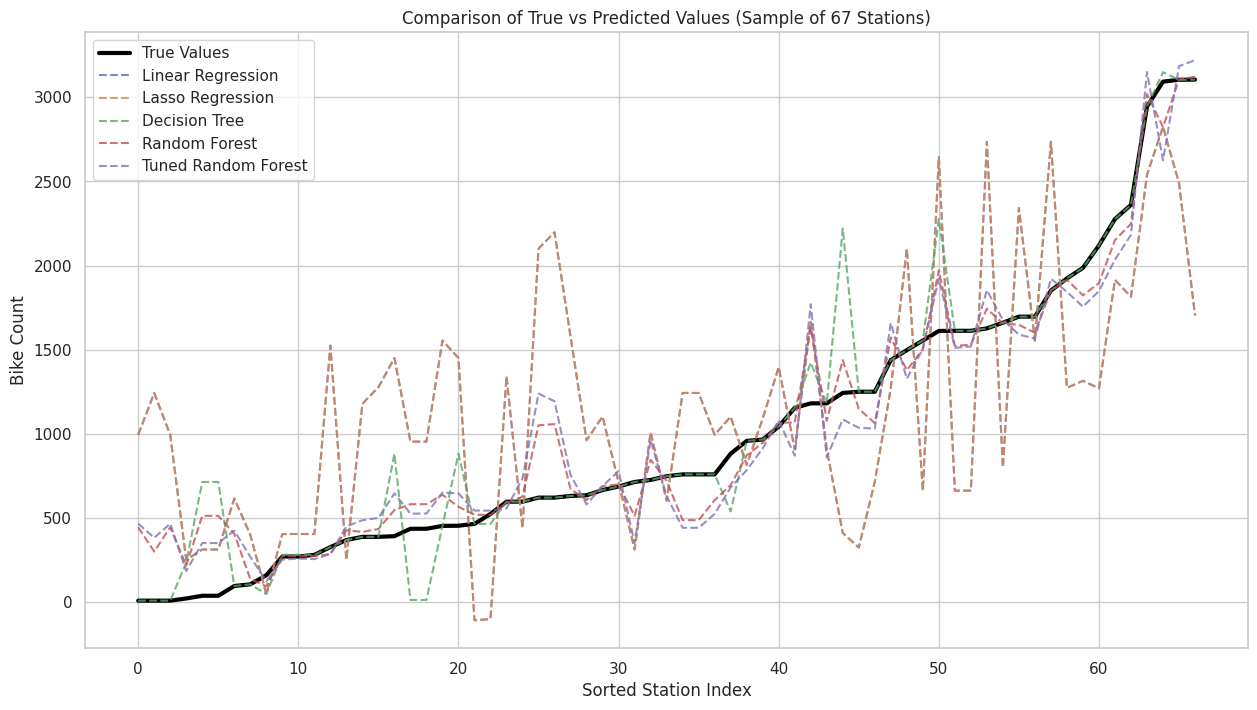

In [29]:

#  Global Comparison Plot


y_test_reset = y_test.reset_index(drop=True)

# Construction of the comparison DataFrame
plot_df = pd.DataFrame({'True Values': y_test_reset})

for model_name, y_pred in predictions_dict.items():
    plot_df[model_name] = y_pred

# Sample for readability
sample_size = min(200, len(plot_df))

plot_sample = (
    plot_df.sample(n=sample_size, random_state=42)
            .sort_values(by='True Values')
            .reset_index(drop=True)
)

plt.figure(figsize=(15, 8))
plt.plot(plot_sample['True Values'], label='True Values', color='black', linewidth=3)

# Plot all models
for model_name in predictions_dict.keys():
    plt.plot(
        plot_sample[model_name],
        label=model_name,
        linestyle='--',
        alpha=0.8
    )

plt.title(f'Comparison of True vs Predicted Values (Sample of {sample_size} Stations)')
plt.xlabel('Sorted Station Index')
plt.ylabel('Bike Count')
plt.legend()
plt.grid(True)
plt.show()


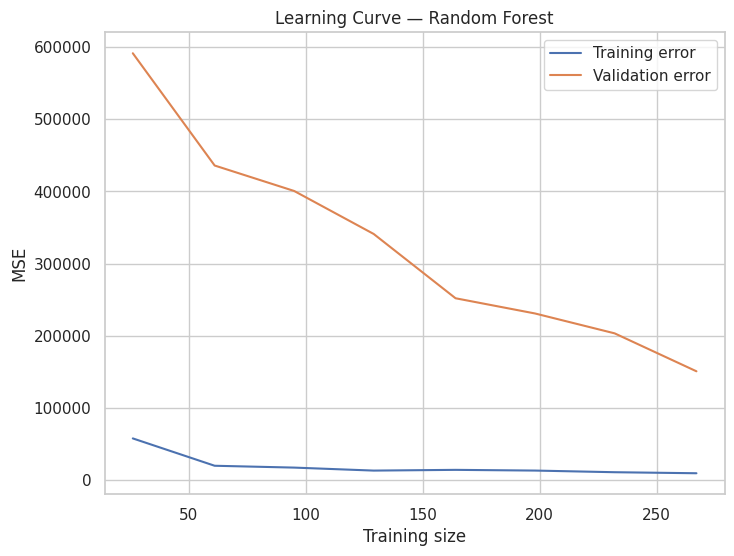

In [30]:


def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.title(title)
    plt.xlabel("Training size")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execution for Random Forest
rf_model_for_curve = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

plot_learning_curve(rf_model_for_curve, "Learning Curve — Random Forest")


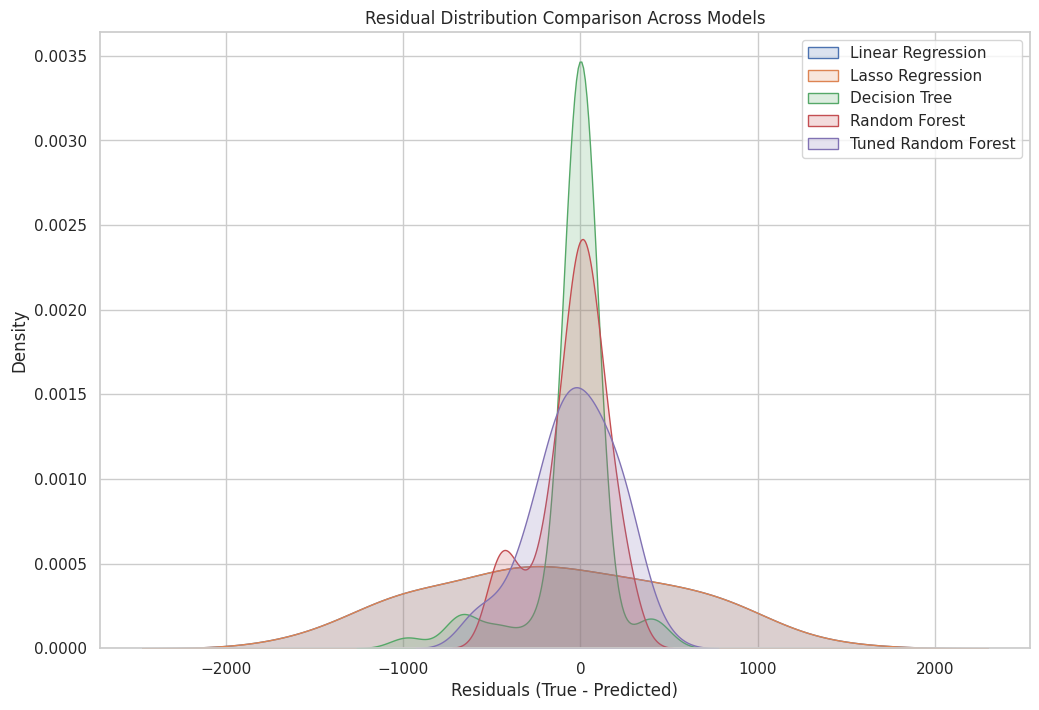

In [31]:
#Residual Distribution Comparison Across Models
plt.figure(figsize=(12, 8))

for model_name, y_pred in predictions_dict.items():
    sns.kdeplot(y_test - y_pred, label=model_name, fill=True, alpha=0.2)

plt.title("Residual Distribution Comparison Across Models")
plt.xlabel("Residuals (True - Predicted)")
plt.legend()
plt.grid(True)
plt.show()


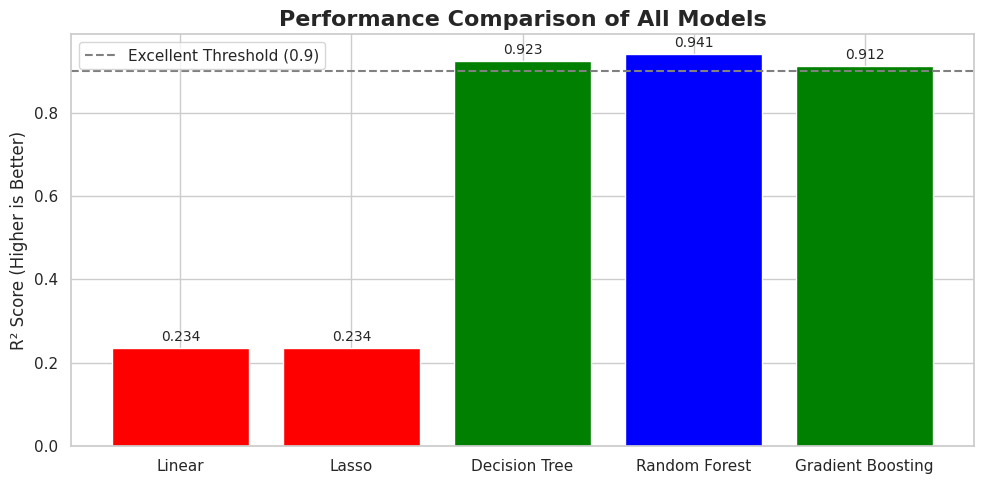

In [32]:



# Data
models = ['Linear', 'Lasso', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
r2_scores = [0.234, 0.234, 0.923, 0.941, 0.912]


plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_scores, color=['red', 'red', 'green', 'blue', 'green'])


plt.title('Performance Comparison of All Models', fontsize=16, fontweight='bold')
plt.ylabel('R² Score (Higher is Better)', fontsize=12)
plt.axhline(y=0.9, color='grey', linestyle='--', label='Excellent Threshold (0.9)')
plt.legend()

# Adding value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


NUMERIC FEATURES = ['distance_to_stop_line', 'number_of_lanes', 'reference_year', 'longitude', 'latitude', 'population_2022']
CATEGORICAL FEATURES = ['peak_flow_hour', 'sensor_type', 'measurement_post_type', 'commune']

TOP FEATURES:
                            Feature  Importance
3                         longitude    0.384413
4                          latitude    0.259718
23   commune_Lyon 3e Arrondissement    0.121212
5                   population_2022    0.119973
2                    reference_year    0.062524
7              peak_flow_hour_08h00    0.015190
13             peak_flow_hour_18h00    0.010135
1                   number_of_lanes    0.004856
24   commune_Lyon 4e Arrondissement    0.004024
20                     commune_Lyon    0.003569
8              peak_flow_hour_11h00    0.003473
14             peak_flow_hour_19h00    0.002744
12             peak_flow_hour_17h00    0.002694
32             commune_Villeurbanne    0.001357
26   commune_Lyon 6e Arrondissement    0.0011

/tmp/ipython-input-3335945705.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


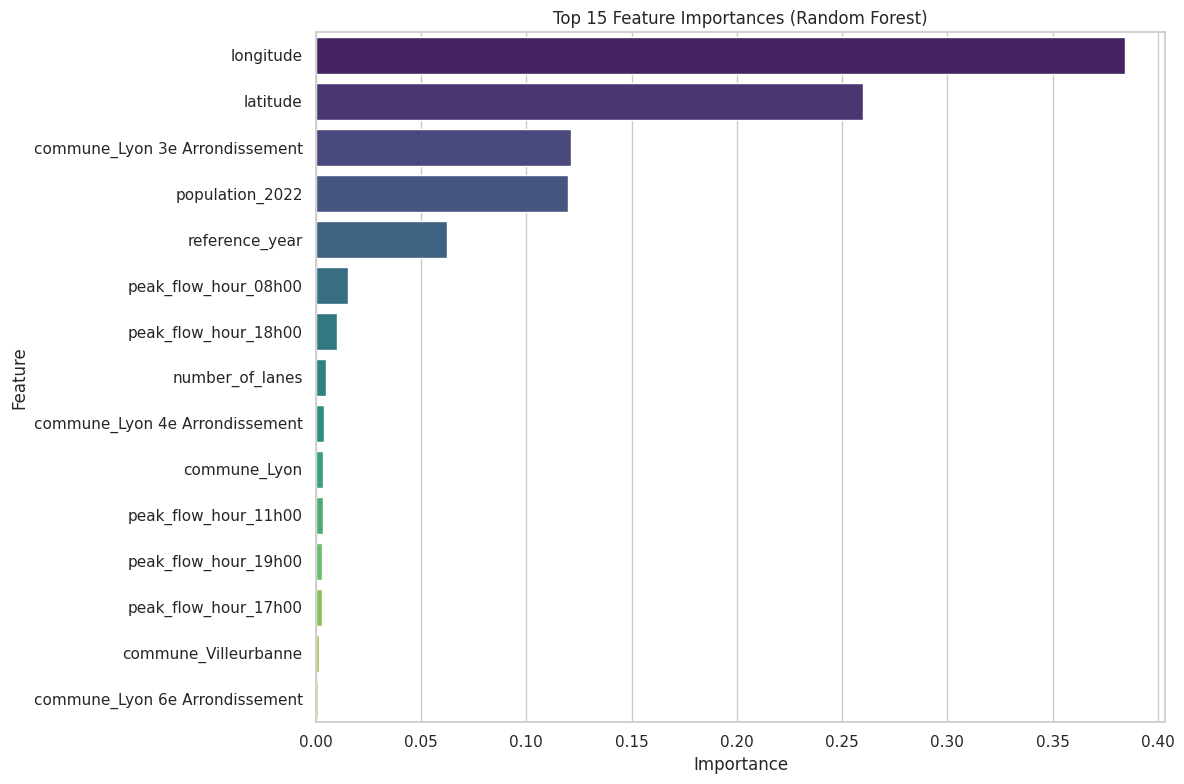

In [33]:


# 1. RECONSTRUCTION OF X AND y

target = "average_week_day_bike_count"

if target not in df_final.columns:
    raise ValueError(f"The column {target} does not exist in df_final!")

y = df_final[target]
X = df_final.drop(columns=[target])



# 2. AUTOMATIC IDENTIFICATION OF NUMERIC / CATEGORICAL COLUMNS

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNUMERIC FEATURES =", numeric_features)
print("CATEGORICAL FEATURES =", categorical_features)



# 3. ROBUST PREPROCESSOR

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)



# 4. RANDOM FOREST TRAINING

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

rf.fit(X, y)



# 5. RECONSTRUCTION OF FEATURE NAMES

# 1) Numerical names = unchanged
final_numeric_names = numeric_features.copy()

# 2) Encoded categorical names
ohe = rf.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]

if categorical_features:
    final_categorical_names = list(ohe.get_feature_names_out(categorical_features))
else:
    final_categorical_names = []

# 3) Merge
final_feature_names = final_numeric_names + final_categorical_names

# Consistency check
if len(final_feature_names) != len(rf.named_steps["model"].feature_importances_):
    print("\n WARNING: mismatch between features and importances")
    print("Feature name count :", len(final_feature_names))
    print("Importance count   :", len(rf.named_steps['model'].feature_importances_))
    raise ValueError("Inconsistency detected.")



# 6. FEATURE IMPORTANCE

feat_imp = pd.DataFrame({
    "Feature": final_feature_names,
    "Importance": rf.named_steps["model"].feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTOP FEATURES:")
print(feat_imp.head(20))



# 7. GRAPHICS

plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_imp.head(15),
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


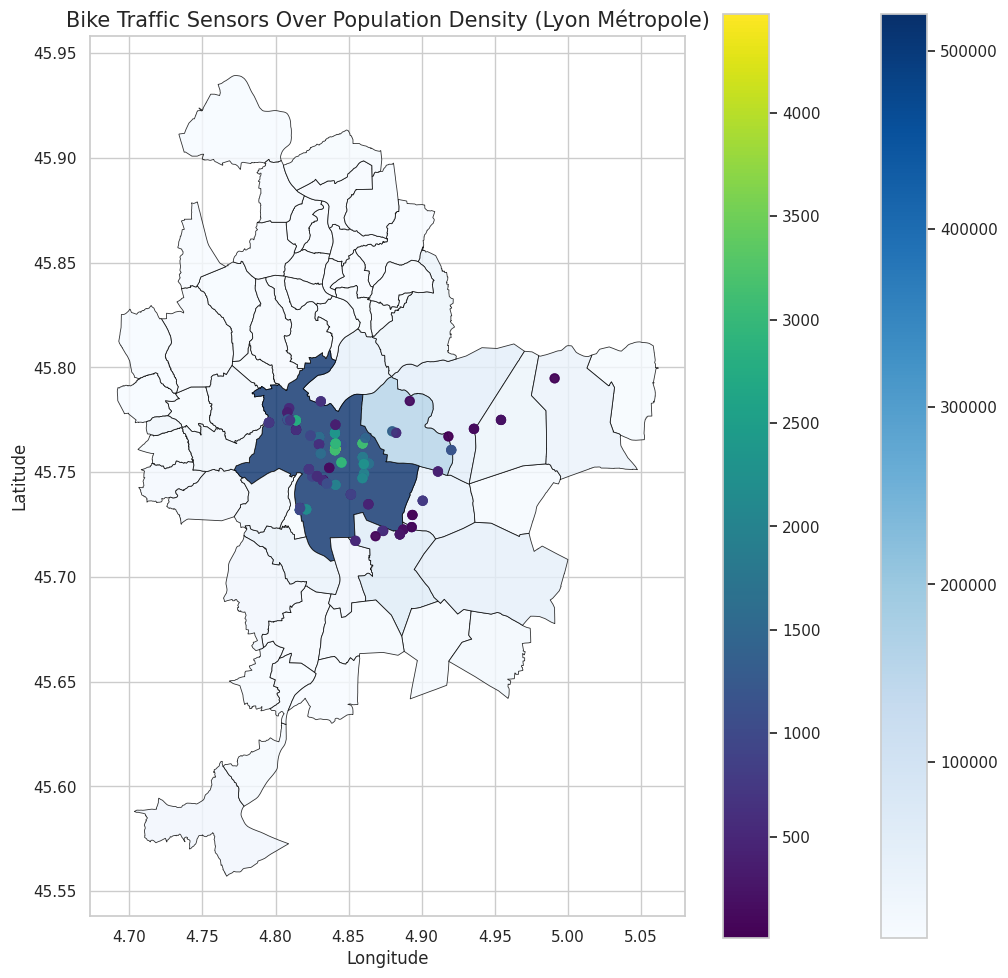

In [34]:


# Transformation df_final into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["longitude"], df_final["latitude"]),
    crs="EPSG:4326"
)

#  Plot
fig, ax = plt.subplots(figsize=(12, 12))

# 1. Choropleth map: population per commune
gdf_communes_clean.plot(
    ax=ax,
    column="pop2022",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.8
)

# 2. Sensor points: colored by average weekday bike traffic
gdf_points.plot(
    ax=ax,
    column="average_week_day_bike_count",
    cmap="viridis",
    markersize=40,
    alpha=0.8,
    legend=True
)

plt.title("Bike Traffic Sensors Over Population Density (Lyon Métropole)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()
